<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_12/DNN_assignment_12_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [2]:

import os
import random
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import torch.optim as optim
from tqdm import tqdm
import time

#Dataset Processing

In [3]:
# Load dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
val_ratio = 0.1
generator = torch.Generator().manual_seed(seed)
use_reduced_data = True

transform = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    # transforms.ColorJitter(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10Dataset = torchvision.datasets.CIFAR10(root='.', download=True)
full_train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transformTest)

if use_reduced_data:
    total_reduced_size = 10000
    selected_indices = torch.randperm(len(full_train_dataset), generator=generator)[:total_reduced_size]
else:
    selected_indices = torch.arange(len(full_train_dataset))

val_size = int(len(selected_indices) * val_ratio)
train_size = len(selected_indices) - val_size
train_indices, val_indices = random_split(selected_indices, [train_size, val_size], generator=generator)


train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform),
    train_indices.indices
)

val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transformTest),
    val_indices.indices
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


#Pretrained model

In [4]:

import torch.nn as nn
from torchvision.models import resnet50, mobilenet_v3_large

def get_resnet50(num_classes=10):
    model = resnet50(pretrained=True)

    # Adjust first conv and maxpool for CIFAR-10 input size
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()

    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last half: layer3, layer4, and fc
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True

    # Replace final classification layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


#Small CNN model

In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Changed input channels to 3 for RGB
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate the flattened size dynamically
        # Input size: 32x32
        # After conv1 and pool: (32/2) x (32/2) = 16x16, with 16 channels -> 16*16*16
        # After conv2 and pool: (16/2) x (16/2) = 8x8, with 32 channels -> 8*8*32 = 2048
        self.fc1 = nn.Linear(32 * 8 * 8, 128) # Corrected input features to 32 * 8 * 8
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 3x32x32 -> 16x16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16x16 -> 32x8x8
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#training funtion

In [6]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.to(device)
    results = []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_acc, val_loss = validation(model, val_loader, device, show_metrics=False)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s)  - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

def validation(model, test_loader, device, show_metrics=True):
    metric = MulticlassAccuracy(num_classes=10).to(device)
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in (test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            metric.update(outputs, labels)
            total_loss += loss.item()

    accuracy_val = metric.compute().item()
    avg_loss = total_loss / len(test_loader)

    if show_metrics:
        print(f"Validation Accuracy: {accuracy_val:.4f} Loss: {avg_loss:.4f}")
    return accuracy_val, avg_loss


def train_knowledge_distillation(teacher, student, train_loader, val_loader, epochs, learning_rate, T, alpha, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(student.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    results = []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()
        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher(inputs)
            student_logits = student(inputs)

            label_loss = criterion(student_logits, labels)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_targets_loss = F.kl_div(soft_prob, soft_targets, reduction='batchmean') * (T ** 2)
            loss = alpha * soft_targets_loss + (1 - alpha) * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(student_logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        val_acc, val_loss = validation(student, val_loader, device, show_metrics=False)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s) - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

#ploating funtion

In [17]:
import matplotlib.pyplot as plt
def plot_history(history, title):
    # Unpack the history
    train_acc = [row[0] for row in history]
    train_loss = [row[1] for row in history]
    val_acc   = [row[2] for row in history]
    val_loss  = [row[3] for row in history]
    epochs = range(1, len(history) + 1)

    # Plotting
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.suptitle(f'{title}', fontsize=16)
    plt.tight_layout()
    plt.show()

#Model Training

In [13]:
model = get_resnet50().cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# trained_model, history_resNet50 = train(model, train_loader, val_loader, device, epochs=30, lr=0.001)
epochs = 30
learning_rate = 1e-3
history_resnet50 = train(model, train_loader, val_loader, epochs, learning_rate, device)
validation(model, test_loader, device)

Epoch 1/30(26.57s)  - accuracy: 0.3540  - loss: 1.8988  - val_accuracy: 0.4967  - val_loss: 1.6445
Epoch 2/30(19.23s)  - accuracy: 0.4800  - loss: 1.6337  - val_accuracy: 0.5047  - val_loss: 1.5710
Epoch 3/30(19.25s)  - accuracy: 0.5419  - loss: 1.5158  - val_accuracy: 0.6505  - val_loss: 1.3318
Epoch 4/30(19.51s)  - accuracy: 0.5653  - loss: 1.4572  - val_accuracy: 0.6484  - val_loss: 1.2903
Epoch 5/30(19.60s)  - accuracy: 0.5978  - loss: 1.3974  - val_accuracy: 0.6702  - val_loss: 1.2572
Epoch 6/30(20.58s)  - accuracy: 0.6208  - loss: 1.3521  - val_accuracy: 0.7143  - val_loss: 1.1536
Epoch 7/30(19.51s)  - accuracy: 0.6472  - loss: 1.3094  - val_accuracy: 0.6965  - val_loss: 1.1924
Epoch 8/30(19.80s)  - accuracy: 0.6617  - loss: 1.2692  - val_accuracy: 0.7271  - val_loss: 1.1331
Epoch 9/30(19.78s)  - accuracy: 0.6768  - loss: 1.2422  - val_accuracy: 0.7465  - val_loss: 1.0930
Epoch 10/30(20.03s)  - accuracy: 0.6926  - loss: 1.1990  - val_accuracy: 0.7220  - val_loss: 1.1775
Epoch 11/

(0.8199999928474426, 0.9344079729857718)

In [11]:
scratch_student = SmallCNN().to(device)
history_scratch = train(scratch_student, train_loader, val_loader, epochs, learning_rate, device)
validation(scratch_student, test_loader, device)


Epoch 1/30(8.80s)  - accuracy: 0.2704  - loss: 2.0732  - val_accuracy: 0.3898  - val_loss: 1.8612
Epoch 2/30(8.85s)  - accuracy: 0.3590  - loss: 1.8807  - val_accuracy: 0.4511  - val_loss: 1.6939
Epoch 3/30(7.50s)  - accuracy: 0.4007  - loss: 1.7953  - val_accuracy: 0.4752  - val_loss: 1.6198
Epoch 4/30(8.63s)  - accuracy: 0.4293  - loss: 1.7475  - val_accuracy: 0.4989  - val_loss: 1.5806
Epoch 5/30(7.91s)  - accuracy: 0.4466  - loss: 1.7152  - val_accuracy: 0.5087  - val_loss: 1.5505
Epoch 6/30(8.10s)  - accuracy: 0.4618  - loss: 1.6800  - val_accuracy: 0.5135  - val_loss: 1.5372
Epoch 7/30(8.59s)  - accuracy: 0.4699  - loss: 1.6554  - val_accuracy: 0.5451  - val_loss: 1.5020
Epoch 8/30(7.71s)  - accuracy: 0.4756  - loss: 1.6459  - val_accuracy: 0.5470  - val_loss: 1.5063
Epoch 9/30(8.33s)  - accuracy: 0.4897  - loss: 1.6188  - val_accuracy: 0.5447  - val_loss: 1.4856
Epoch 10/30(8.66s)  - accuracy: 0.5024  - loss: 1.5891  - val_accuracy: 0.5520  - val_loss: 1.4919
Epoch 11/30(7.55s) 

(0.6225000023841858, 1.3487998019358156)

#knowledge distilation

In [15]:
T, alpha = 4, 0.8

history_kd = train_knowledge_distillation(model, scratch_student, train_loader, val_loader, epochs, learning_rate, T=T, alpha=alpha, device=device)
validation(scratch_student, test_loader, device)

Epoch 1/30(10.65s) - accuracy: 0.5420  - loss: 1.0016  - val_accuracy: 0.5868  - val_loss: 1.3844
Epoch 2/30(10.69s) - accuracy: 0.5479  - loss: 0.9732  - val_accuracy: 0.5974  - val_loss: 1.4012
Epoch 3/30(10.51s) - accuracy: 0.5517  - loss: 0.9764  - val_accuracy: 0.6188  - val_loss: 1.3585
Epoch 4/30(10.25s) - accuracy: 0.5524  - loss: 0.9580  - val_accuracy: 0.6126  - val_loss: 1.3667
Epoch 5/30(10.13s) - accuracy: 0.5589  - loss: 0.9388  - val_accuracy: 0.6313  - val_loss: 1.3533
Epoch 6/30(10.78s) - accuracy: 0.5692  - loss: 0.9346  - val_accuracy: 0.6109  - val_loss: 1.3613
Epoch 7/30(10.63s) - accuracy: 0.5689  - loss: 0.9242  - val_accuracy: 0.6179  - val_loss: 1.3435
Epoch 8/30(10.71s) - accuracy: 0.5771  - loss: 0.9288  - val_accuracy: 0.6202  - val_loss: 1.3341
Epoch 9/30(10.57s) - accuracy: 0.5731  - loss: 0.9169  - val_accuracy: 0.6378  - val_loss: 1.3220
Epoch 10/30(9.88s) - accuracy: 0.5831  - loss: 0.9024  - val_accuracy: 0.6206  - val_loss: 1.3301
Epoch 11/30(10.71s) 

(0.6633999943733215, 1.2700359145547175)

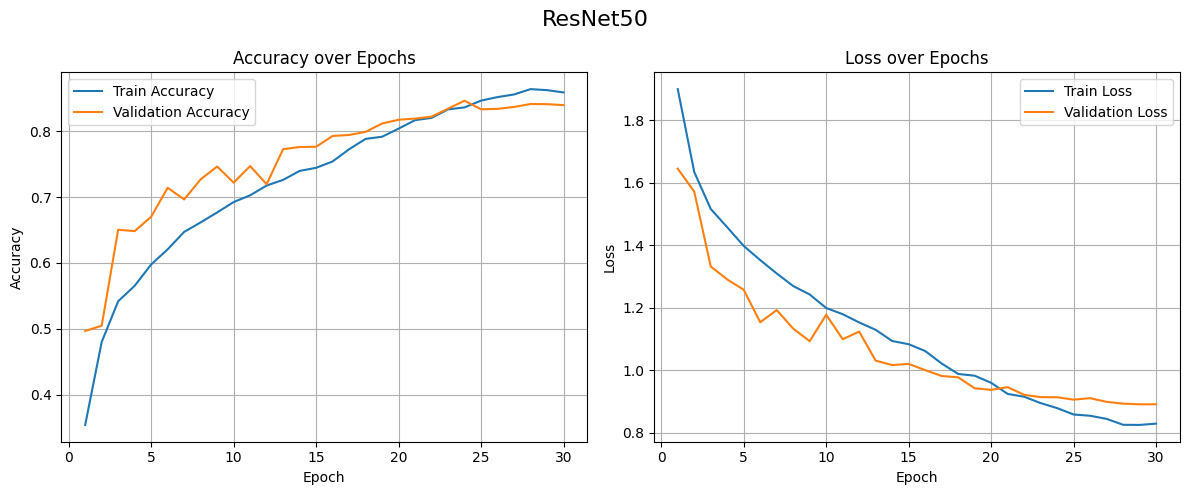

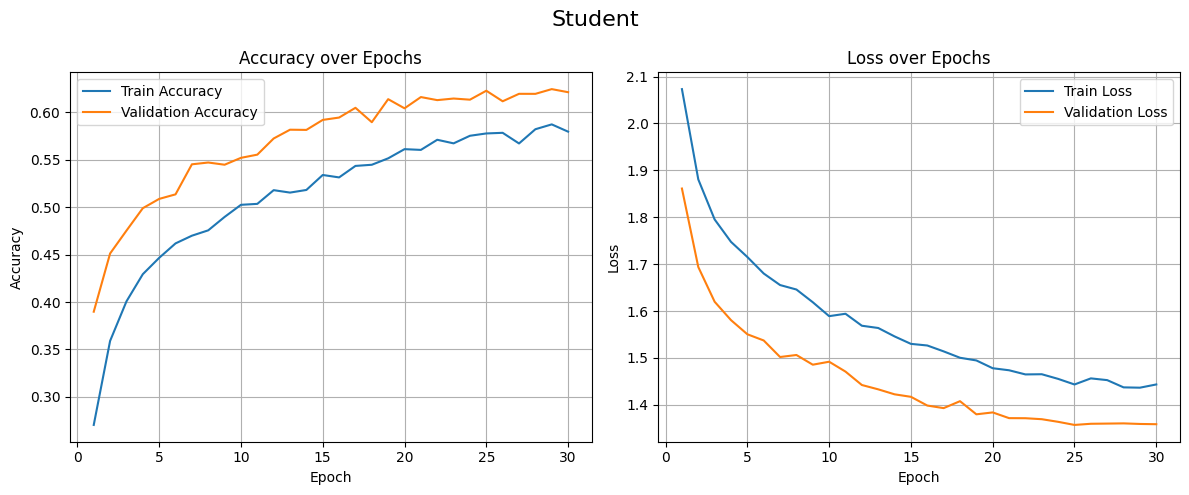

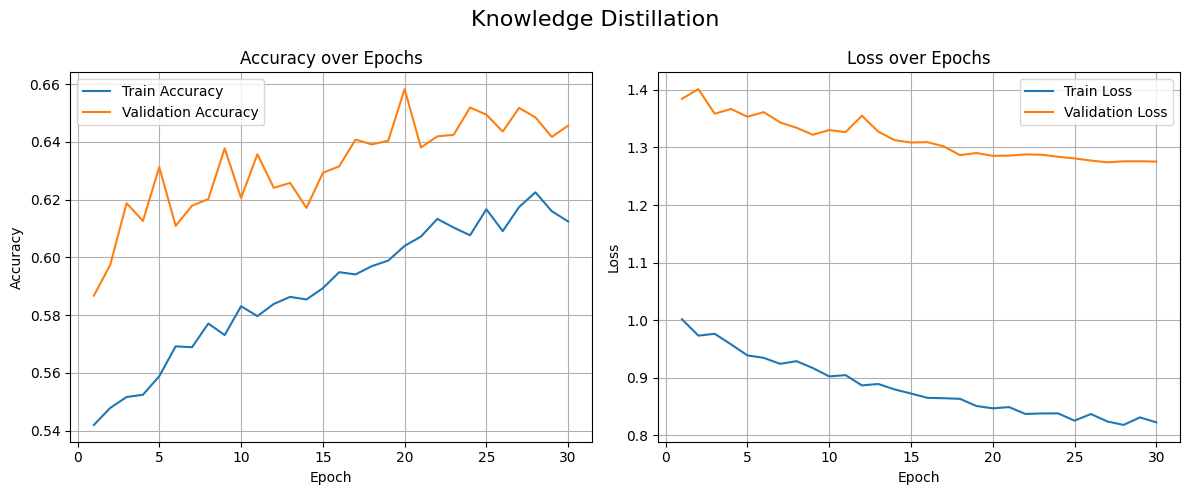

In [18]:
plot_history(history_resnet50, 'ResNet50')
plot_history(history_scratch, 'Student')
plot_history(history_kd, 'Knowledge Distillation')